## Check for LLM variations


In [2]:
# Combine multiple Turtle files into one

input_files = [
    "data/LLM_data/healthcareorganizations.ttl",
    "data/LLM_data/persons.ttl",
    "data/LLM_data/servicedepartments.ttl"
]
output_file = "data/LLM_data/combined.ttl"

with open(output_file, "w", encoding="utf-8") as outfile:
    for fname in input_files:
        with open(fname, "r", encoding="utf-8") as infile:
            outfile.write(infile.read())
            outfile.write("\n")  # Ensure separation between files

print(f"Combined Turtle files saved to {output_file}")

Combined Turtle files saved to data/LLM_data/combined.ttl


In [ ]:
import pandas as pd
golden_standard_clean = pd.read_csv("data/LLM_data/ground_truth_LLM.csv", encoding="utf-8")
# Filter all rows where variation_type is 'omission'
# These rows will be removed from the dataframe
# Remove pairs where either row (with same original_id and duplicate_id) has variation_type 'omission'

golden_standard = golden_standard_clean.copy()
# Only remove rows where (original_id, duplicate_id, field_name) matches an omission row
to_remove = golden_standard[
    golden_standard['variation_type'] == 'omission'
][['original_id', 'duplicate_id', 'field_name']] 

mask = golden_standard.set_index(['original_id', 'duplicate_id', 'field_name']).index.isin(
    to_remove.set_index(['original_id', 'duplicate_id', 'field_name']).index
)
golden_standard_filtered = golden_standard[~mask]
golden_standard_filtered = golden_standard[golden_standard['variation_type'] != 'omission']

# Keep only one row per original_id (e.g., the first occurrence)
golden_standard_filtered = golden_standard_filtered.drop_duplicates(subset=['original_id'], keep='first')
golden_standard = golden_standard_filtered

Matching Statistics for Hacky:
Number of matches in Hacky: 2644
Total Duplicates in Golden Standard: 681
Total Matched Duplicates: 76
Percentage Matched (%): 11.16

Precision: 0.0287
Recall: 0.1116

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 457
Total Duplicates in Golden Standard: 681
Total Matched Duplicates: 285
Percentage Matched (%): 41.85

Precision: 0.6236
Recall: 0.4185

Matching Statistics for TransE:
Number of matches in TransE: 454
Total Duplicates in Golden Standard: 681
Total Matched Duplicates: 297
Percentage Matched (%): 43.61

Precision: 0.6542
Recall: 0.4361

Matching Statistics for Distmult:
Number of matches in Distmult: 486
Total Duplicates in Golden Standard: 681
Total Matched Duplicates: 310
Percentage Matched (%): 45.52

Precision: 0.6379
Recall: 0.4552

Matching Statistics for Node2vec:
Number of matches in Node2vec: 412
Total Duplicates in Golden Standard: 681
Total Matched Duplicates: 281
Percentage Matched (%): 41.26

Precisi

,Precision,Recall
Hacky,0.0287,0.1116
Sent_filtered2,0.6236,0.4185
TransE,0.6542,0.4361
Distmult,0.6379,0.4552
Node2vec,0.6820,0.4126
NetMf,0.5628,0.1909
DeepWalk,0.5917,0.3128


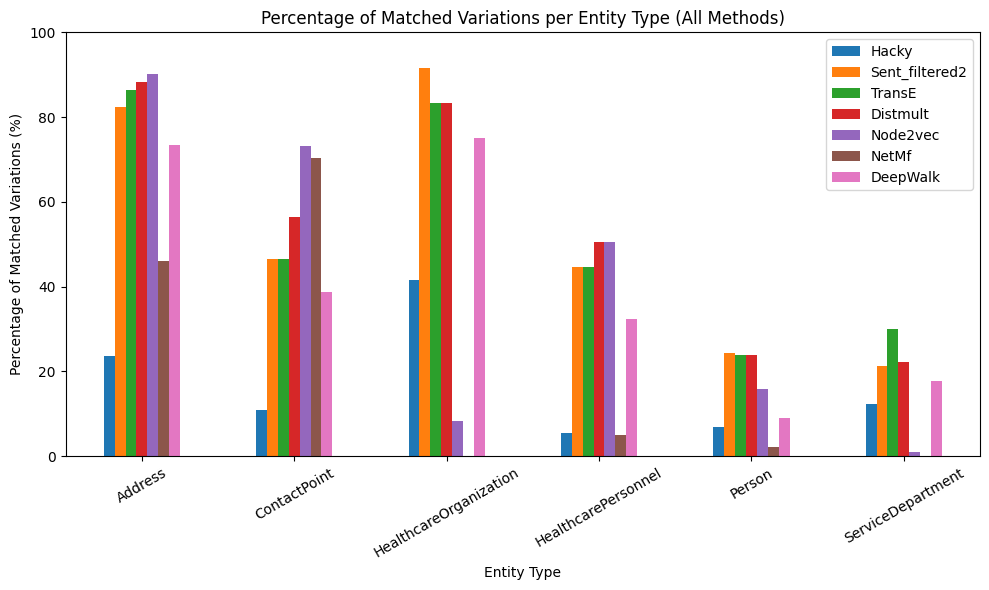

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt


# Load both match files
match_files = {
    'Hacky': json.load(open('matches_LLM/matchesHacky.json', 'r')),
    'Sent_filtered2': json.load(open('matches_LLM/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches_LLM/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult': json.load(open('matches_LLM/HybridDistmult_alpha_0.5.json', 'r')),
    'Node2vec': json.load(open('matches_LLM/HybridNode2vec_alpha_0.5.json', 'r')),
    'NetMf' : json.load(open('matches_LLM/HybridNetMf_alpha_0.5.json', 'r')),
    'DeepWalk' : json.load(open('matches_LLM/HybridDeepWalk_alpha_0.5.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
precision_recall_summary = {} 
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })
    # Calculate precision and recall
    # True Positives (TP): matched pairs that are in golden_standard
    TP = matched
    # False Positives (FP): matched pairs that are NOT in golden_standard
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    FP = len(matched_pairs_set - golden_pairs_set)
    # False Negatives (FN): golden_standard pairs not matched
    FN = len(golden_pairs_set - matched_pairs_set)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall}

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\n")

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched

pr_df = pd.DataFrame(precision_recall_summary).T  # Transpose for better display
pr_df = pr_df.round(4)
print("Precision and Recall per Method:")
display(pr_df)

percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   

In [5]:
# Count how many ServiceDepartment matches were in the golden standard and how many were actually matched

# Total ServiceDepartment matches in golden standard
total_sd_golden = golden_standard[golden_standard['entity_type'] == 'ServiceDepartment'].shape[0]

# Actually matched ServiceDepartment
matched_sd = matched_rows[matched_rows['entity_type'] == 'ServiceDepartment'].shape[0]

print(f"Total ServiceDepartment matches in golden standard: {total_sd_golden}")
print(f"ServiceDepartment matches actually found: {matched_sd}") 
# Find matched pairs that are NOT in the golden standard (i.e., false positives)
false_positive_pairs = matched_pairs_set - golden_pairs_set

# Convert set of pairs to DataFrame for inspection
fp_list = []
for e1, e2 in false_positive_pairs:
    fp_list.append({'entity1': e1, 'entity2': e2})
false_positives_df = pd.DataFrame(fp_list)

print(f"Number of false positive matches (not in golden standard): {len(false_positives_df)}")
false_positives_df.head()

Total ServiceDepartment matches in golden standard: 113
ServiceDepartment matches actually found: 33
Number of false positive matches (not in golden standard): 498


,entity1,entity2
0,38c1608a-e634-4141-b569-90df6e2a2b5e,38c1608a-e634-4141-b569-90df6e2a2b5e
1,68c299b1-7c38-4fb9-8c3a-19ffa930360c,68c299b1-7c38-4fb9-8c3a-19ffa930360c
2,79afe7fd-b6ac-4f61-8b6e-26d7200fdfb8,79afe7fd-b6ac-4f61-8b6e-26d7200fdfb8
3,27429e56-f0fc-464a-b0b9-08df9b6f8426,27429e56-f0fc-464a-b0b9-08df9b6f8426
4,eb59d4df-ce21-454b-84c8-ead75bf38980,eb59d4df-ce21-454b-84c8-ead75bf38980


In [17]:
# Find all golden standard matches that were NOT found by the last algorithm run in the loop
missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

print(f"Number of missed matches: {len(missed_rows)}")
missed_rows.head()  # Show a sample

Number of missed matches: 468


,row,original_id,field_name,original_value,varied_value,variation_type,entity_type,duplicate_id
3,3,5d393bf9-b2da-41f6-8c16-014a2e4a6e78,healthcareOrganizationName,Perez-Becker Gesundheitszentrum,PG,Organization Name Abbreviation,HealthcareOrganization,HCO4
4,5,3e332f35-086c-4768-b0fe-3cfc991ab513,healthcareOrganizationName,Novak PLC Tervisekeskus,Noavk PLC Tervisekeskus,Organization Name Typo,HealthcareOrganization,HCO6
9,11,8b5885ca-0bb2-43f0-bd30-291a55fea08e,healthcareOrganizationName,"Mcneil, Gonzalez and Howard Tervisekeskus",M Gonzalez and Howard Tervisekeskus,Organization Name Abbreviation,HealthcareOrganization,HCO12
12,0,daf66c5f-2577-4ffa-887a-746319c16a0d,postalCode,9573,9573,Postal Code Formatting Variations,Address,Ad15
28,8,3856be31-f568-49c6-833c-14694f06ea18,text,Zakariasingel 13,Zakariasingel 13B,Street Number Manipulation,Address,Ad7


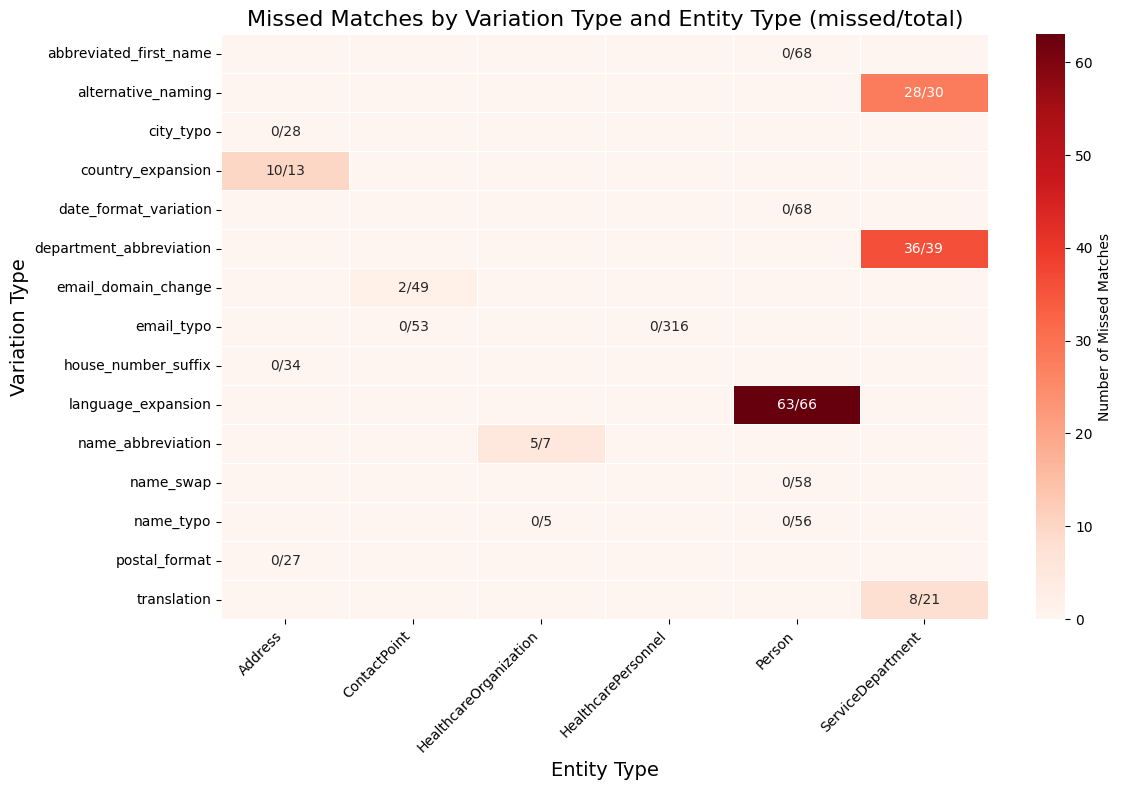

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missed_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import json

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_filtered.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_filtered.json', 'r')),
}

def extract_uuid(uri):
    return uri.split("/")[-1]

# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

 # Set pandas display options to use the full width of the notebook
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)
    print(f"Combined Variation and Entity-Type Analysis for {match_type}:")
    print(variation_frame)
   

Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Matching Statistics for TransE:
Number of matches in TransE: 0
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 0
Percentage Matched (%): 0.00

Matching Statistics for Distmult:
Number of matches in Distmult: 569
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 590
Percentage Matched (%): 62.90

Matching Statistics for Node2vec:
Number of matches in Node2vec: 354
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 271
Percentage Matched (%): 28.89

Matching Statistics for NetMf:
Number of matches in NetMf: 607
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 685
Percentage Ma

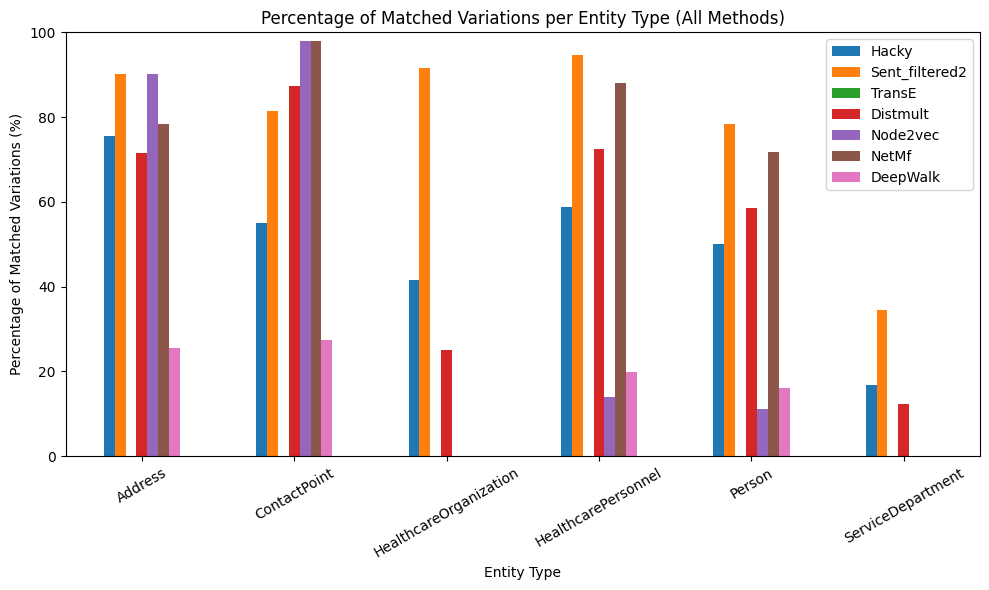

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches/HybridTransE_alpha_0.0.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_alpha_0.0.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_alpha_0.0.json', 'r')),
    'NetMf' : json.load(open('matches/HybridNetMf_alpha_0.0.json', 'r')),
    'DeepWalk' : json.load(open('matches/HybridDeepWalk_alpha_0.0.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched


percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   